# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

import itertools

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb


%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True

# Data and EDA

In [2]:
df = pd.read_csv('data/loan_data.csv')
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [4]:
df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


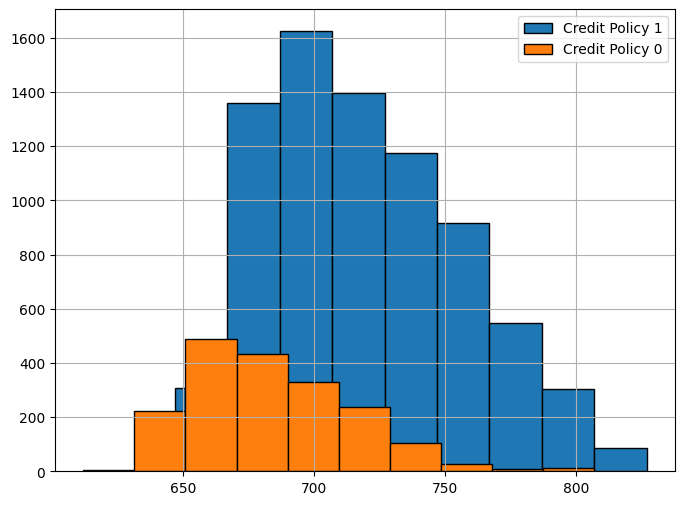

In [5]:
#Distrubutions of FICO scores between customer meets criteria for credit and customer did not meet.
fig, ax = plt.subplots(figsize=(8, 6))

subset_1 = df[df['credit.policy'] == 1].fico.hist(label='Credit Policy 1')
subset_2 = df[df['credit.policy'] == 0].fico.hist(label= 'Credit Policy 0')

plt.legend()
plt.show()

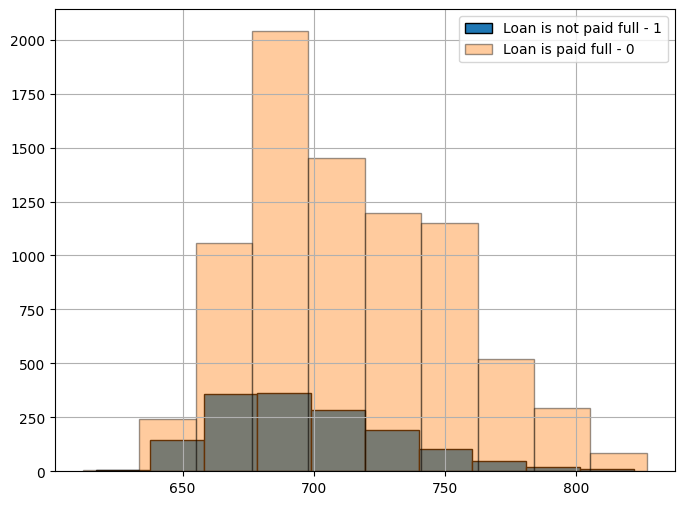

In [6]:
#Distrubution of FICO scores between Loan is fully paid and not fully paid
fig, ax = plt.subplots(figsize=(8,6))

df[df['not.fully.paid'] == 1].fico.hist(label='Loan is not paid full - 1')
df[df['not.fully.paid'] == 0].fico.hist(alpha=0.4 ,label='Loan is paid full - 0')

plt.legend()
plt.show()

<Axes: xlabel='purpose', ylabel='count'>

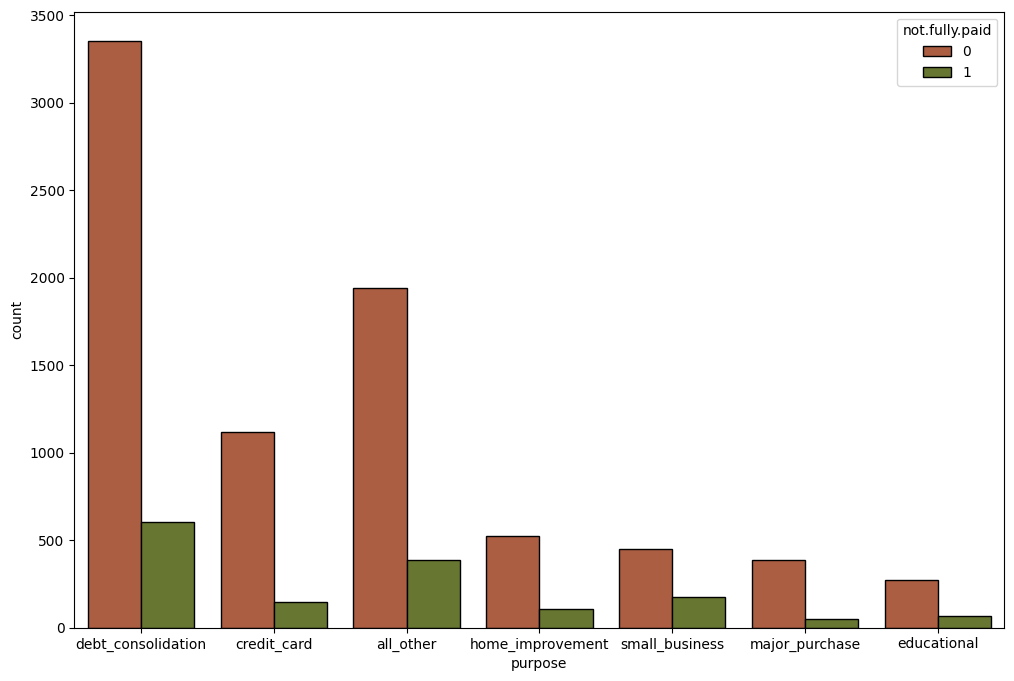

In [7]:
#Plot the counts of loans by purpese accoridng to not.fully.paid

plt.figure(figsize=(12,8))
custom_colors = ['#BD5630', '#6D8325'] 
sns.countplot(x='purpose', hue='not.fully.paid', data=df, palette=custom_colors)

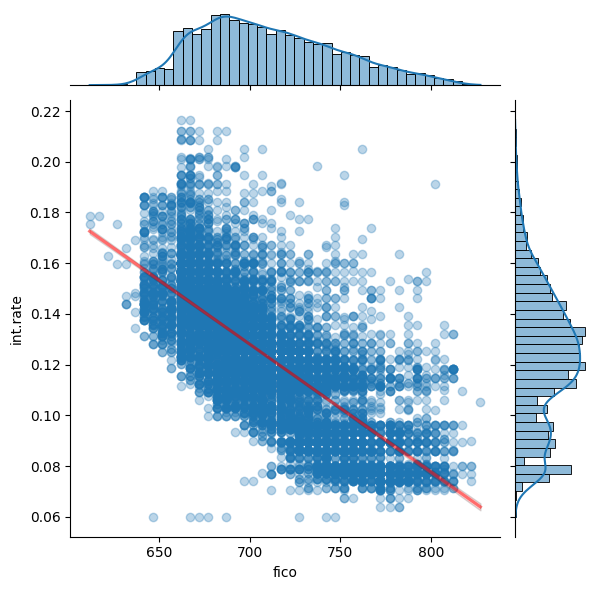

In [8]:
# Plot the trend between FICO and interst rate

sns.jointplot(x='fico', y='int.rate', kind='reg', data=df, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red', 'alpha':0.5})

plt.show()

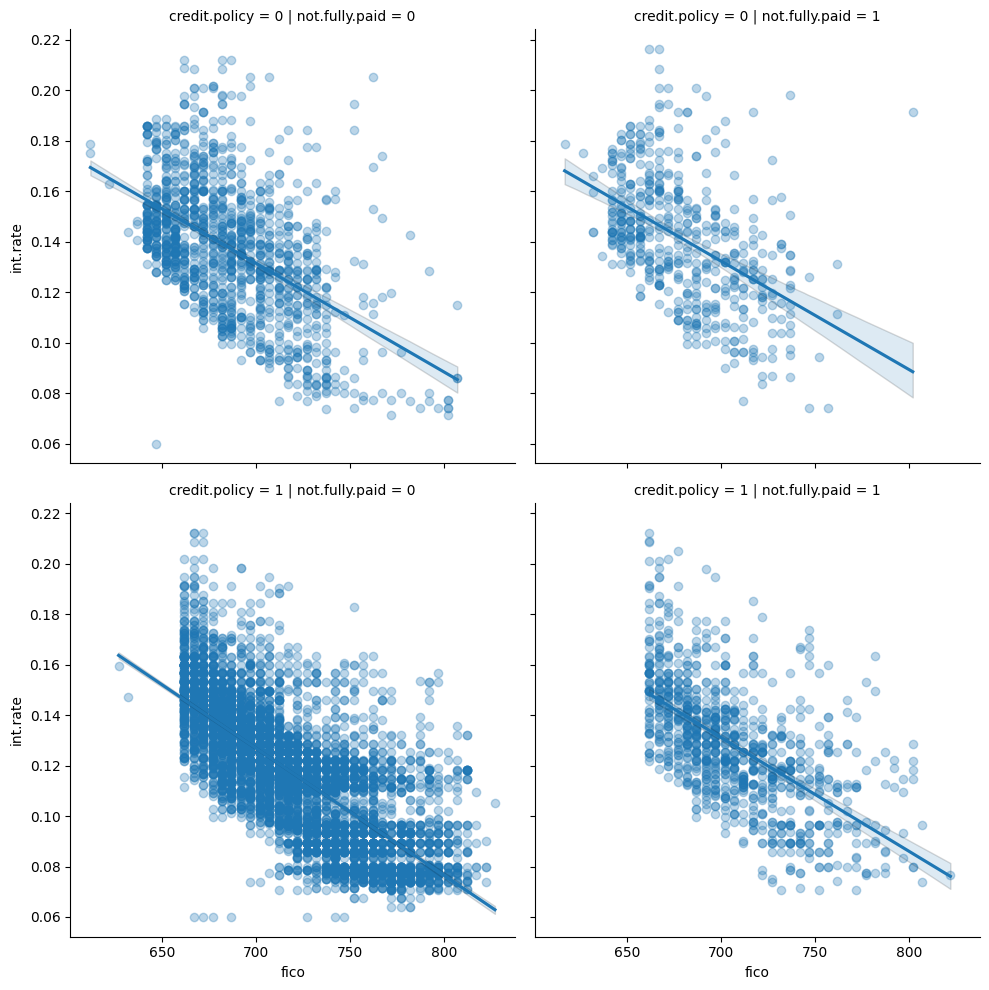

In [9]:
# Lets add not.fully.paid and credit.policy to this

sns.lmplot(data=df, x='fico', y='int.rate', col='not.fully.paid', row='credit.policy', scatter_kws={'alpha': 0.3})



In [10]:
# Set categorical features

cat_feats = ['purpose']

In [11]:
# Create dummies to expand our dataset

final_data = pd.get_dummies(df, columns=cat_feats, drop_first=True) #drop_first = True to avoid multicollinearity

final_data

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,False,True,False,False,False,False
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,True,False,False,False,False,False
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,False,True,False,False,False,False
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,False,True,False,False,False,False
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1,False,False,False,False,False,False
9574,0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1,False,False,False,False,False,False
9575,0,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1,False,True,False,False,False,False
9576,0,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1,False,False,False,True,False,False


In [12]:
a = final_data[final_data['not.fully.paid'] == 1]
b = final_data[final_data['not.fully.paid'] == 0]
print('Number of not.full.paid = 1:', a.shape[0])
print('Number of not.full.paid = 0:', b.shape[0]) # Because of this difference we need stratify in our train-test split

Number of not.full.paid = 1: 1533
Number of not.full.paid = 0: 8045


### Train-Test Split

In [13]:
y = final_data['not.fully.paid']
X = final_data.drop('not.fully.paid', axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Baseline Model - Decision Tree

In [15]:
# Call the model
dtree = DecisionTreeClassifier()

In [16]:
# Fit the model

dtree.fit(X_train, y_train)

DecisionTreeClassifier()

Predictions and Evaluation of Decision Tree

In [17]:
y_pred = dtree.predict(X_train)
y_pred_prob = dtree.predict_proba(X_train)[:,1]

prediction = dtree.predict(X_test)
probability = dtree.predict_proba(X_test)[:,1]

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1609
           1       0.21      0.23      0.22       307

    accuracy                           0.74      1916
   macro avg       0.53      0.53      0.53      1916
weighted avg       0.75      0.74      0.74      1916



In [18]:
# Define function for confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)


Confusion matrix, without normalization
[[1339  270]
 [ 237   70]]


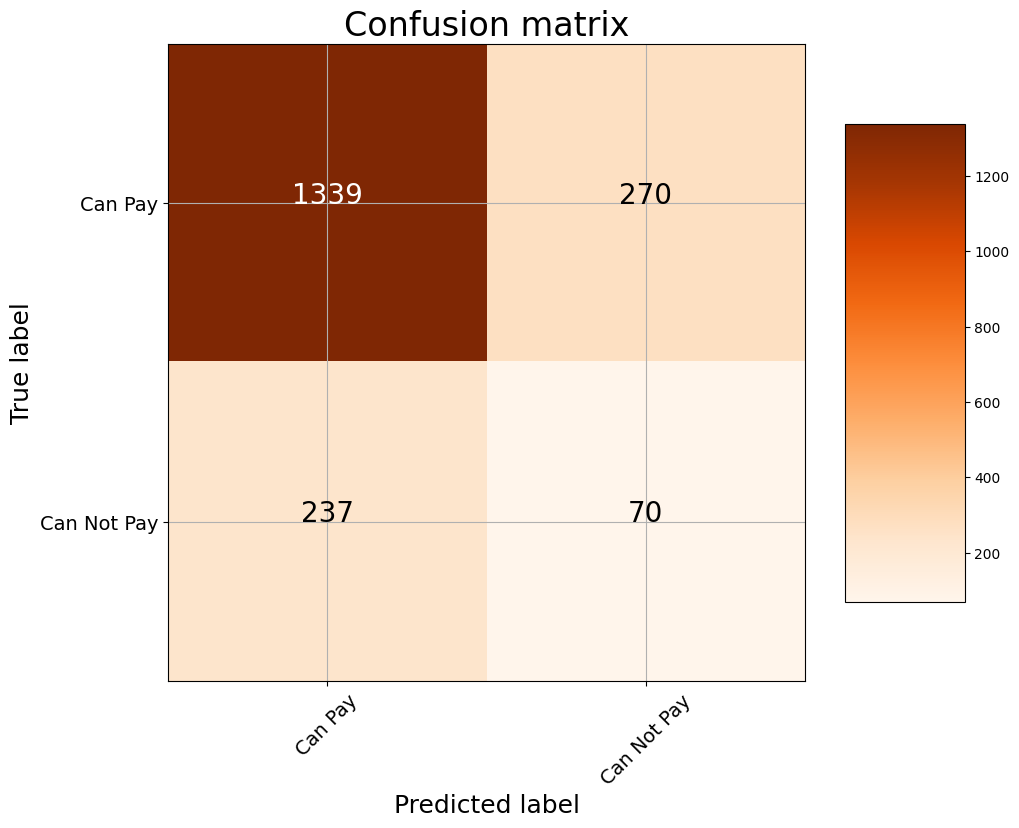

In [19]:

cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = ['Can Pay', 'Can Not Pay'])

In [20]:
# Define function for compare baseline performance and shows ROC Curve

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves')

In [21]:
test_labels = y_test
train_labels = y_train

Recall Baseline: 1.0 Test: 0.23 Train: 1.0
Precision Baseline: 0.16 Test: 0.21 Train: 1.0
Roc Baseline: 0.5 Test: 0.53 Train: 1.0


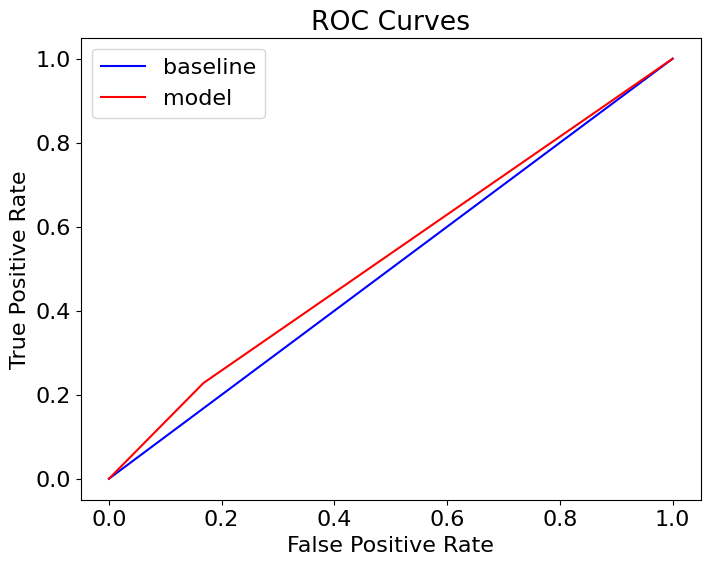

In [22]:
evaluate_model(prediction, probability, y_pred, y_pred_prob)

## Random Forest

In [23]:
# Call and fit the model
rand_tree = RandomForestClassifier(n_estimators=100, random_state=42, max_features='sqrt',
                                   n_jobs=-1, verbose=1)

rand_tree.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [24]:
#Store predictions and probabilies in variables
rand_predict_train = rand_tree.predict(X_train)
rand_prob_train = rand_tree.predict_proba(X_train)[:,1]

rand_predict_test = rand_tree.predict(X_test)
rand_prob_test = rand_tree.predict_proba(X_test)[:,1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [25]:
print(classification_report(y_test, rand_predict_test))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1609
           1       0.21      0.01      0.02       307

    accuracy                           0.84      1916
   macro avg       0.53      0.50      0.46      1916
weighted avg       0.74      0.84      0.77      1916



Confusion matrix, without normalization
[[1598   11]
 [ 304    3]]


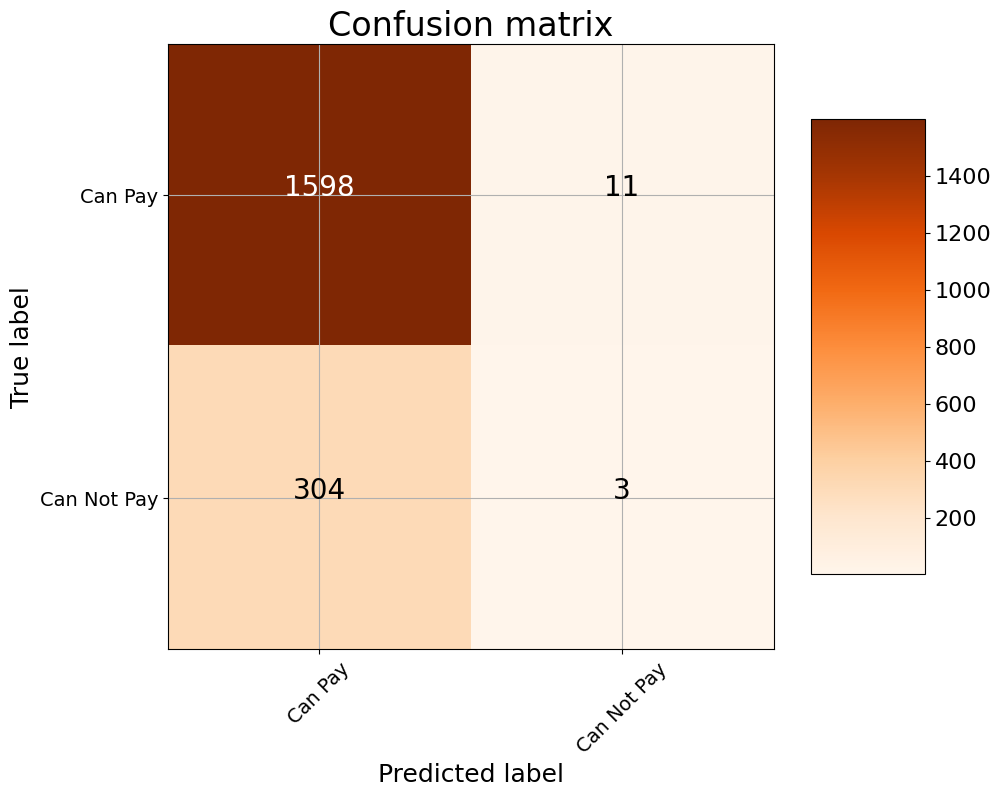

In [26]:
cm_rand = confusion_matrix(y_test, rand_predict_test)
plot_confusion_matrix(cm_rand, classes = ['Can Pay', 'Can Not Pay'])

Recall Baseline: 1.0 Test: 0.01 Train: 1.0
Precision Baseline: 0.16 Test: 0.21 Train: 1.0
Roc Baseline: 0.5 Test: 0.65 Train: 1.0


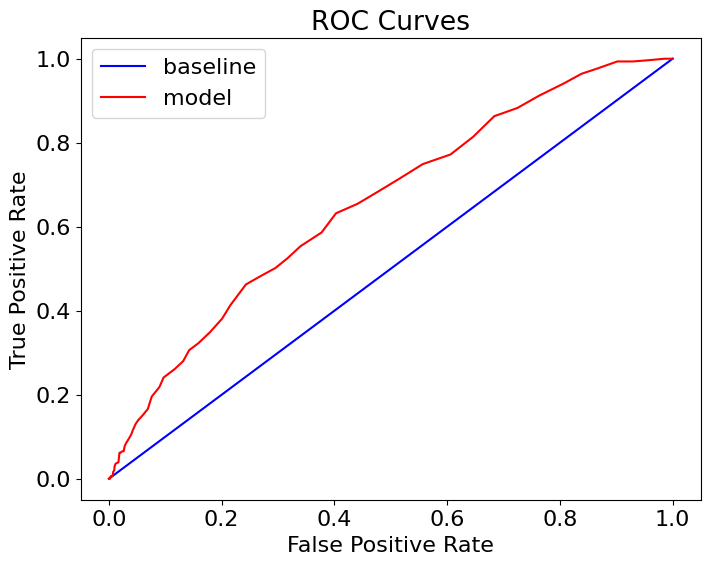

In [27]:
evaluate_model(rand_predict_test, rand_prob_test, rand_predict_train, rand_prob_train)

Seems like we have improvet our model. Now will try to improve with Randomize Search 

## Randomize Search

In [28]:
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 42)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 5, random_state=42)

In [29]:
# Fit the model
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV 1/3] END bootstrap=False, max_depth=13, max_features=0.6, max_leaf_nodes=36, min_samples_split=10, n_estimators=48;, score=0.671 total time=   1.1s
[CV 2/3] END bootstrap=False, max_depth=13, max_features=0.6, max_leaf_nodes=36, min_samples_split=10, n_estimators=48;, score=0.641 total time=   1.2s
[CV 3/3] END bootstrap=False, max_depth=13, max_features=0.6, max_leaf_nodes=36, min_samples_split=10, n_estimators=48;, score=0.665 total time=   1.2s
[CV 1/3] END bootstrap=False, max_depth=17, max_features=0.5, max_leaf_nodes=18, min_samples_split=10, n_estimators=149;, score=0.673 total time=   2.9s
[CV 2/3] END bootstrap=False, max_depth=17, max_features=0.5, max_leaf_nodes=18, min_samples_split=10, n_estimators=149;, score=0.649 total time=   3.0s
[CV 3/3] END bootstrap=False, max_depth=17, max_features=0.5, max_leaf_nodes=18, min_samples_split=10, n_estimators=149;, score=0.667 total time=   3.0s


/Users/burakbedir/Desktop/B/Project-Search-Docs/Credit-Risk-Random-Tree/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/burakbedir/Desktop/B/Project-Search-Docs/Credit-Risk-Random-Tree/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/3] END bootstrap=False, max_depth=17, max_features=0.6, max_leaf_nodes=46, min_samples_split=2, n_estimators=134;, score=0.669 total time=   3.3s
[CV 2/3] END bootstrap=False, max_depth=17, max_features=0.6, max_leaf_nodes=46, min_samples_split=2, n_estimators=134;, score=0.643 total time=   3.5s


/Users/burakbedir/Desktop/B/Project-Search-Docs/Credit-Risk-Random-Tree/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/3] END bootstrap=True, max_depth=14, max_features=auto, max_leaf_nodes=31, min_samples_split=2, n_estimators=157;, score=0.677 total time=   1.5s
[CV 2/3] END bootstrap=True, max_depth=14, max_features=auto, max_leaf_nodes=31, min_samples_split=2, n_estimators=157;, score=0.661 total time=   1.5s
[CV 3/3] END bootstrap=False, max_depth=17, max_features=0.6, max_leaf_nodes=46, min_samples_split=2, n_estimators=134;, score=0.665 total time=   3.5s
[CV 3/3] END bootstrap=True, max_depth=14, max_features=auto, max_leaf_nodes=31, min_samples_split=2, n_estimators=157;, score=0.670 total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=10, max_features=sqrt, max_leaf_nodes=17, min_samples_split=2, n_estimators=172;, score=0.679 total time=   1.5s
[CV 1/3] END bootstrap=False, max_depth=19, max_features=0.5, max_leaf_nodes=45, min_samples_split=2, n_estimators=200;, score=0.672 total time=   4.3s
[CV 2/3] END bootstrap=False, max_depth=19, max_features=0.5, max_leaf_nodes=45, min_sam

/Users/burakbedir/Desktop/B/Project-Search-Docs/Credit-Risk-Random-Tree/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/burakbedir/Desktop/B/Project-Search-Docs/Credit-Risk-Random-Tree/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/3] END bootstrap=False, max_depth=5, max_features=0.6, max_leaf_nodes=19, min_samples_split=10, n_estimators=91;, score=0.650 total time=   1.6s
[CV 3/3] END bootstrap=False, max_depth=5, max_features=0.6, max_leaf_nodes=19, min_samples_split=10, n_estimators=91;, score=0.664 total time=   1.6s


/Users/burakbedir/Desktop/B/Project-Search-Docs/Credit-Risk-Random-Tree/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/3] END bootstrap=False, max_depth=12, max_features=auto, max_leaf_nodes=33, min_samples_split=5, n_estimators=79;, score=0.674 total time=   0.9s
[CV 2/3] END bootstrap=False, max_depth=12, max_features=auto, max_leaf_nodes=33, min_samples_split=5, n_estimators=79;, score=0.658 total time=   0.9s
[CV 3/3] END bootstrap=False, max_depth=12, max_features=auto, max_leaf_nodes=33, min_samples_split=5, n_estimators=79;, score=0.668 total time=   0.9s
[CV 3/3] END bootstrap=False, max_depth=19, max_features=0.5, max_leaf_nodes=45, min_samples_split=2, n_estimators=200;, score=0.665 total time=   4.5s
[CV 1/3] END bootstrap=True, max_depth=17, max_features=0.5, max_leaf_nodes=40, min_samples_split=10, n_estimators=126;, score=0.676 total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=17, max_features=0.5, max_leaf_nodes=40, min_samples_split=10, n_estimators=126;, score=0.657 total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=17, max_features=0.5, max_leaf_nodes=40, min_samp

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 12, 12, 12, 12, ...],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 10,  13,  17,  21,  25,  29,  33,  37,  41,  44,  48,  52,  56,
        60,  64,  68,  72,  75,  79,  83,  87,  91,  95,  99, 103, 106,
       110, 114, 118, 122, 126, 130, 134, 137, 141, 145, 149, 153, 157,
       161, 165, 168, 172, 176, 180, 184, 188, 192, 196, 200])},
                   random_state=42, scoring='roc_auc', verbose=5)

In [30]:
# Get the best model with estimators
best_model = rs.best_estimator_
best_model

RandomForestClassifier(max_depth=17, max_features=0.5, max_leaf_nodes=40,
                       min_samples_split=10, n_estimators=126, random_state=42)

In [31]:
best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 17,
 'max_features': 0.5,
 'max_leaf_nodes': 40,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 126,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [32]:
# Get predictions and probabilites according to best model

rf_train_pred = best_model.predict(X_train)
rf_train_prob = best_model.predict_proba(X_train)[:, 1]

rf_predictions = best_model.predict(X_test)
rf_prob = best_model.predict_proba(X_test)[:, 1]

In [33]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1609
           1       0.50      0.00      0.01       307

    accuracy                           0.84      1916
   macro avg       0.67      0.50      0.46      1916
weighted avg       0.79      0.84      0.77      1916



Confusion matrix, without normalization
[[1608    1]
 [ 306    1]]


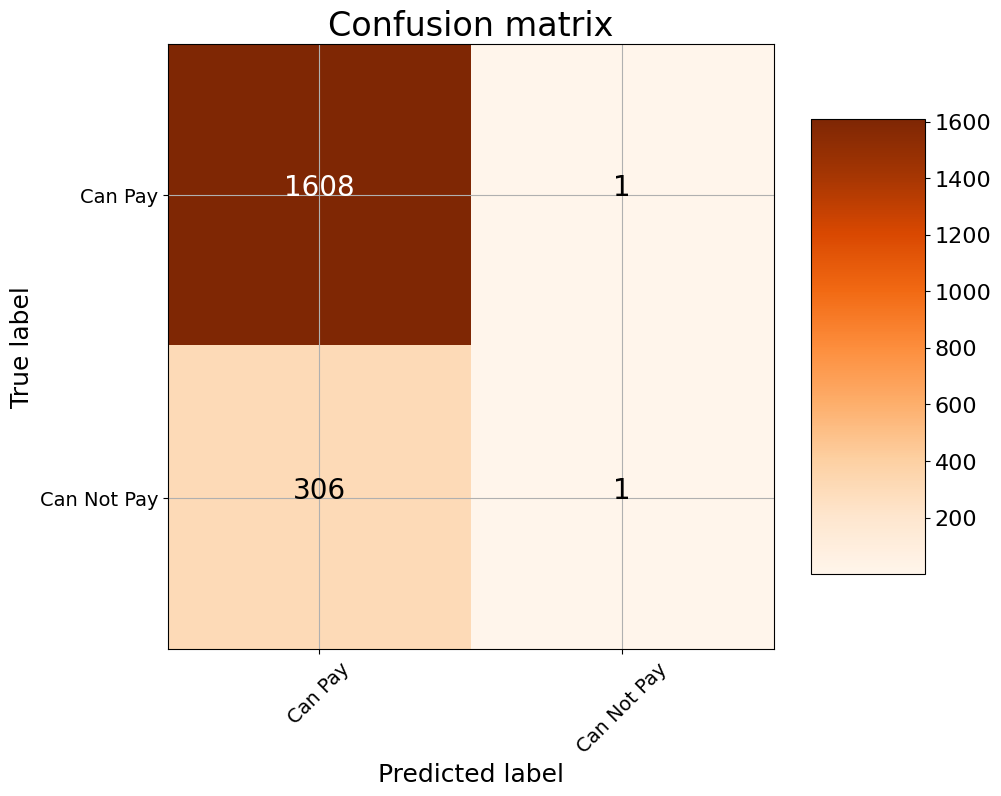

In [34]:
cm_best = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm_best, classes = ['Can Pay', 'Can Not Pay'])

Recall Baseline: 1.0 Test: 0.0 Train: 0.03
Precision Baseline: 0.16 Test: 0.5 Train: 1.0
Roc Baseline: 0.5 Test: 0.67 Train: 0.76


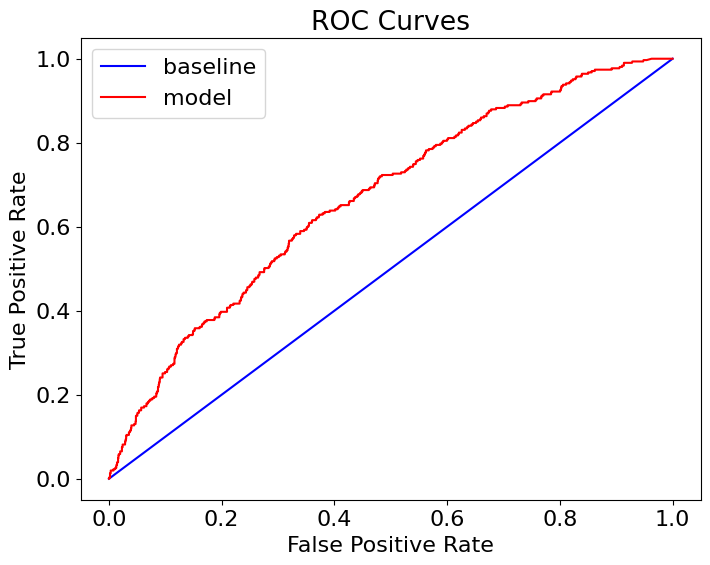

In [35]:
evaluate_model(rf_predictions, rf_prob, rf_train_pred, rf_train_prob)

## XGBoost

In [36]:
#Call and fit model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.1, n_estimators=100)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
# Get predictions and probabilites according to best model

xgb_train_pred = xgb_model.predict(X_train)
xgb_train_prob = xgb_model.predict_proba(X_train)[:, 1]

xgb_predictions = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]

Confusion matrix, without normalization
[[1603    6]
 [ 303    4]]


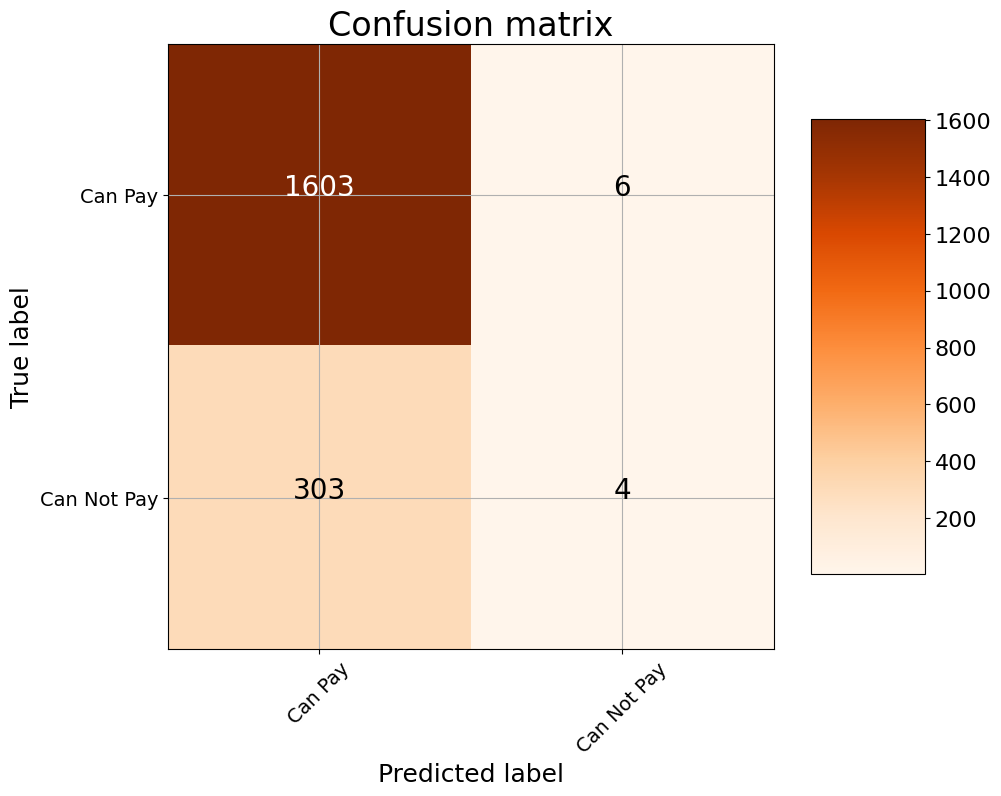

In [38]:
cm_xgb = confusion_matrix(y_test, xgb_predictions)

plot_confusion_matrix(cm_xgb, classes = ['Can Pay', 'Can Not Pay'])

Recall Baseline: 1.0 Test: 0.01 Train: 0.05
Precision Baseline: 0.16 Test: 0.4 Train: 0.93
Roc Baseline: 0.5 Test: 0.67 Train: 0.77


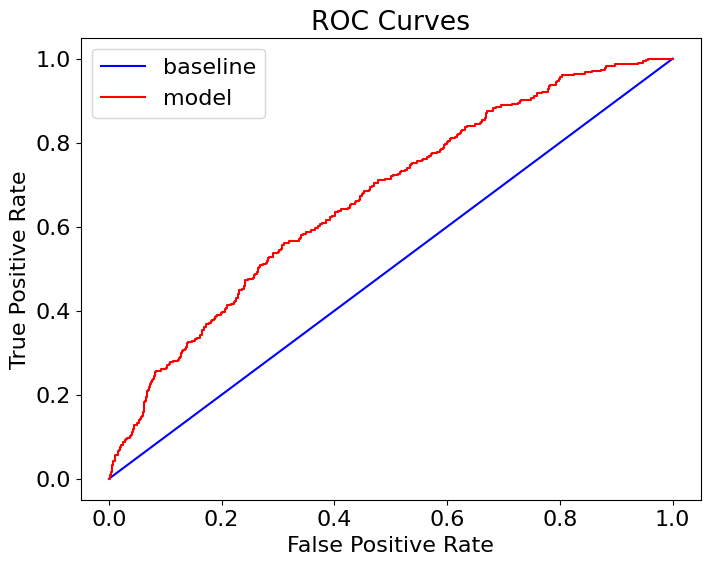

In [39]:
evaluate_model(xgb_predictions, xgb_prob, xgb_train_pred, xgb_train_prob)

### XGBoost with RandomizeSearch

In [40]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4],
    'n_estimators': [50, 100, 200, 300, 400]
}

# Estimator for use in random search
estimator_xgb = xgb.XGBClassifier(objective='binary:logistic')

# Create the random search model
rs_xgb = RandomizedSearchCV(estimator_xgb, param_grid_xgb, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 5, random_state=42)

#Fit the model
rs_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100, subsample=1.0;, score=0.645 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100, subsample=1.0;, score=0.650 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=50, subsample=0.8;, score=0.642 total time=   0.3s
[CV 1/3] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=50, subsample=0.8;, score=0.647 total time=   0.3s
[CV 3/3] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=50, subsample=0.8;, score=0.650 total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100, subsample=1.0;, s

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [50, 100, 200, 300,
                                                         400],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=5)

In [42]:
# Get the best model with estimators
best_model_xgb = rs_xgb.best_estimator_
best_model_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [43]:
best_model_xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1.0,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.4,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 400,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 1.0,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [44]:
#Predictions and Probabilty
xgb_rs_train_pred = best_model_xgb.predict(X_train)
xgb_rs_train_prob = best_model_xgb.predict_proba(X_train)[:, 1]

xgb_rs_predictions = best_model_xgb.predict(X_test)
xgb_rs_prob = best_model_xgb.predict_proba(X_test)[:, 1]

Confusion matrix, without normalization
[[1606    3]
 [ 304    3]]


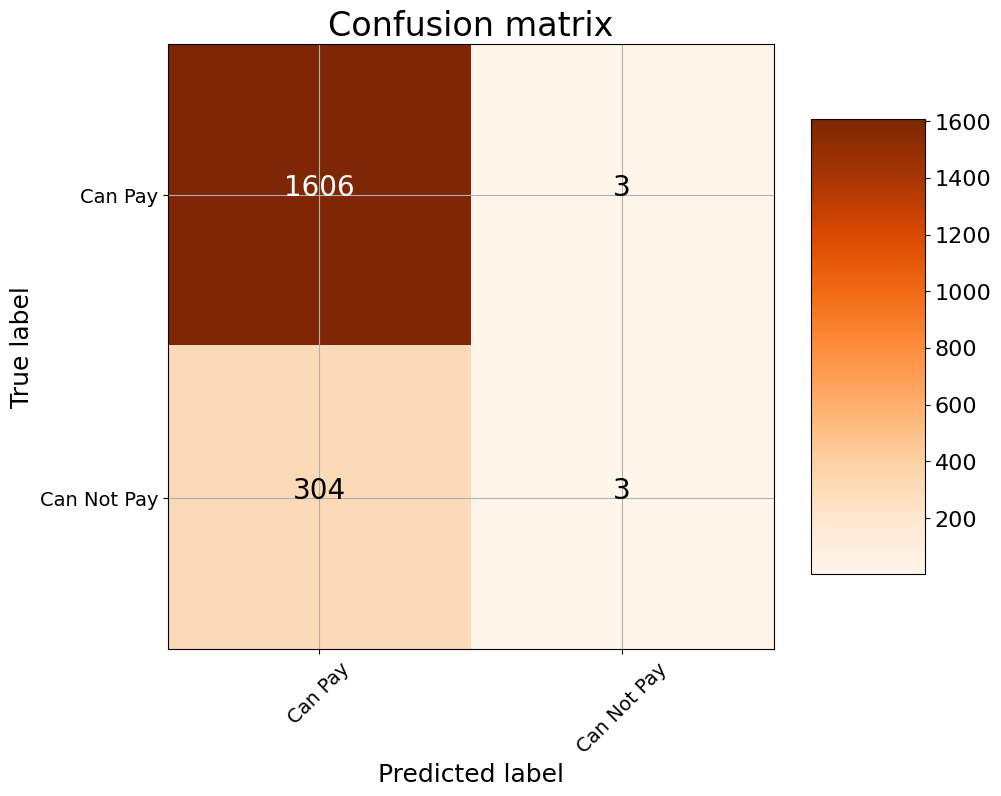

In [45]:
cm_xgb = confusion_matrix(y_test, xgb_rs_predictions)

plot_confusion_matrix(cm_xgb, classes = ['Can Pay', 'Can Not Pay'])

Recall Baseline: 1.0 Test: 0.01 Train: 0.06
Precision Baseline: 0.16 Test: 0.5 Train: 1.0
Roc Baseline: 0.5 Test: 0.66 Train: 0.81


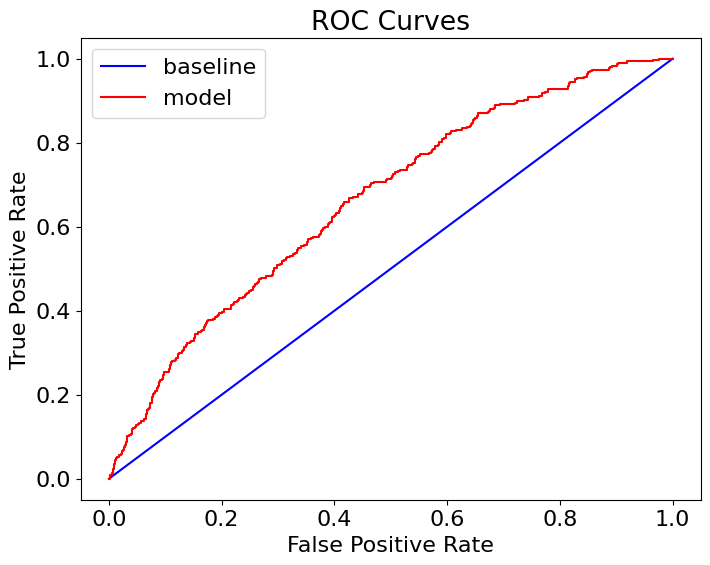

In [46]:
evaluate_model(xgb_rs_predictions, xgb_rs_prob, xgb_rs_train_pred, xgb_rs_train_prob)